# ANALYSIS OF BANK- SHARING DATA USING GRADIENT BASED METHODS

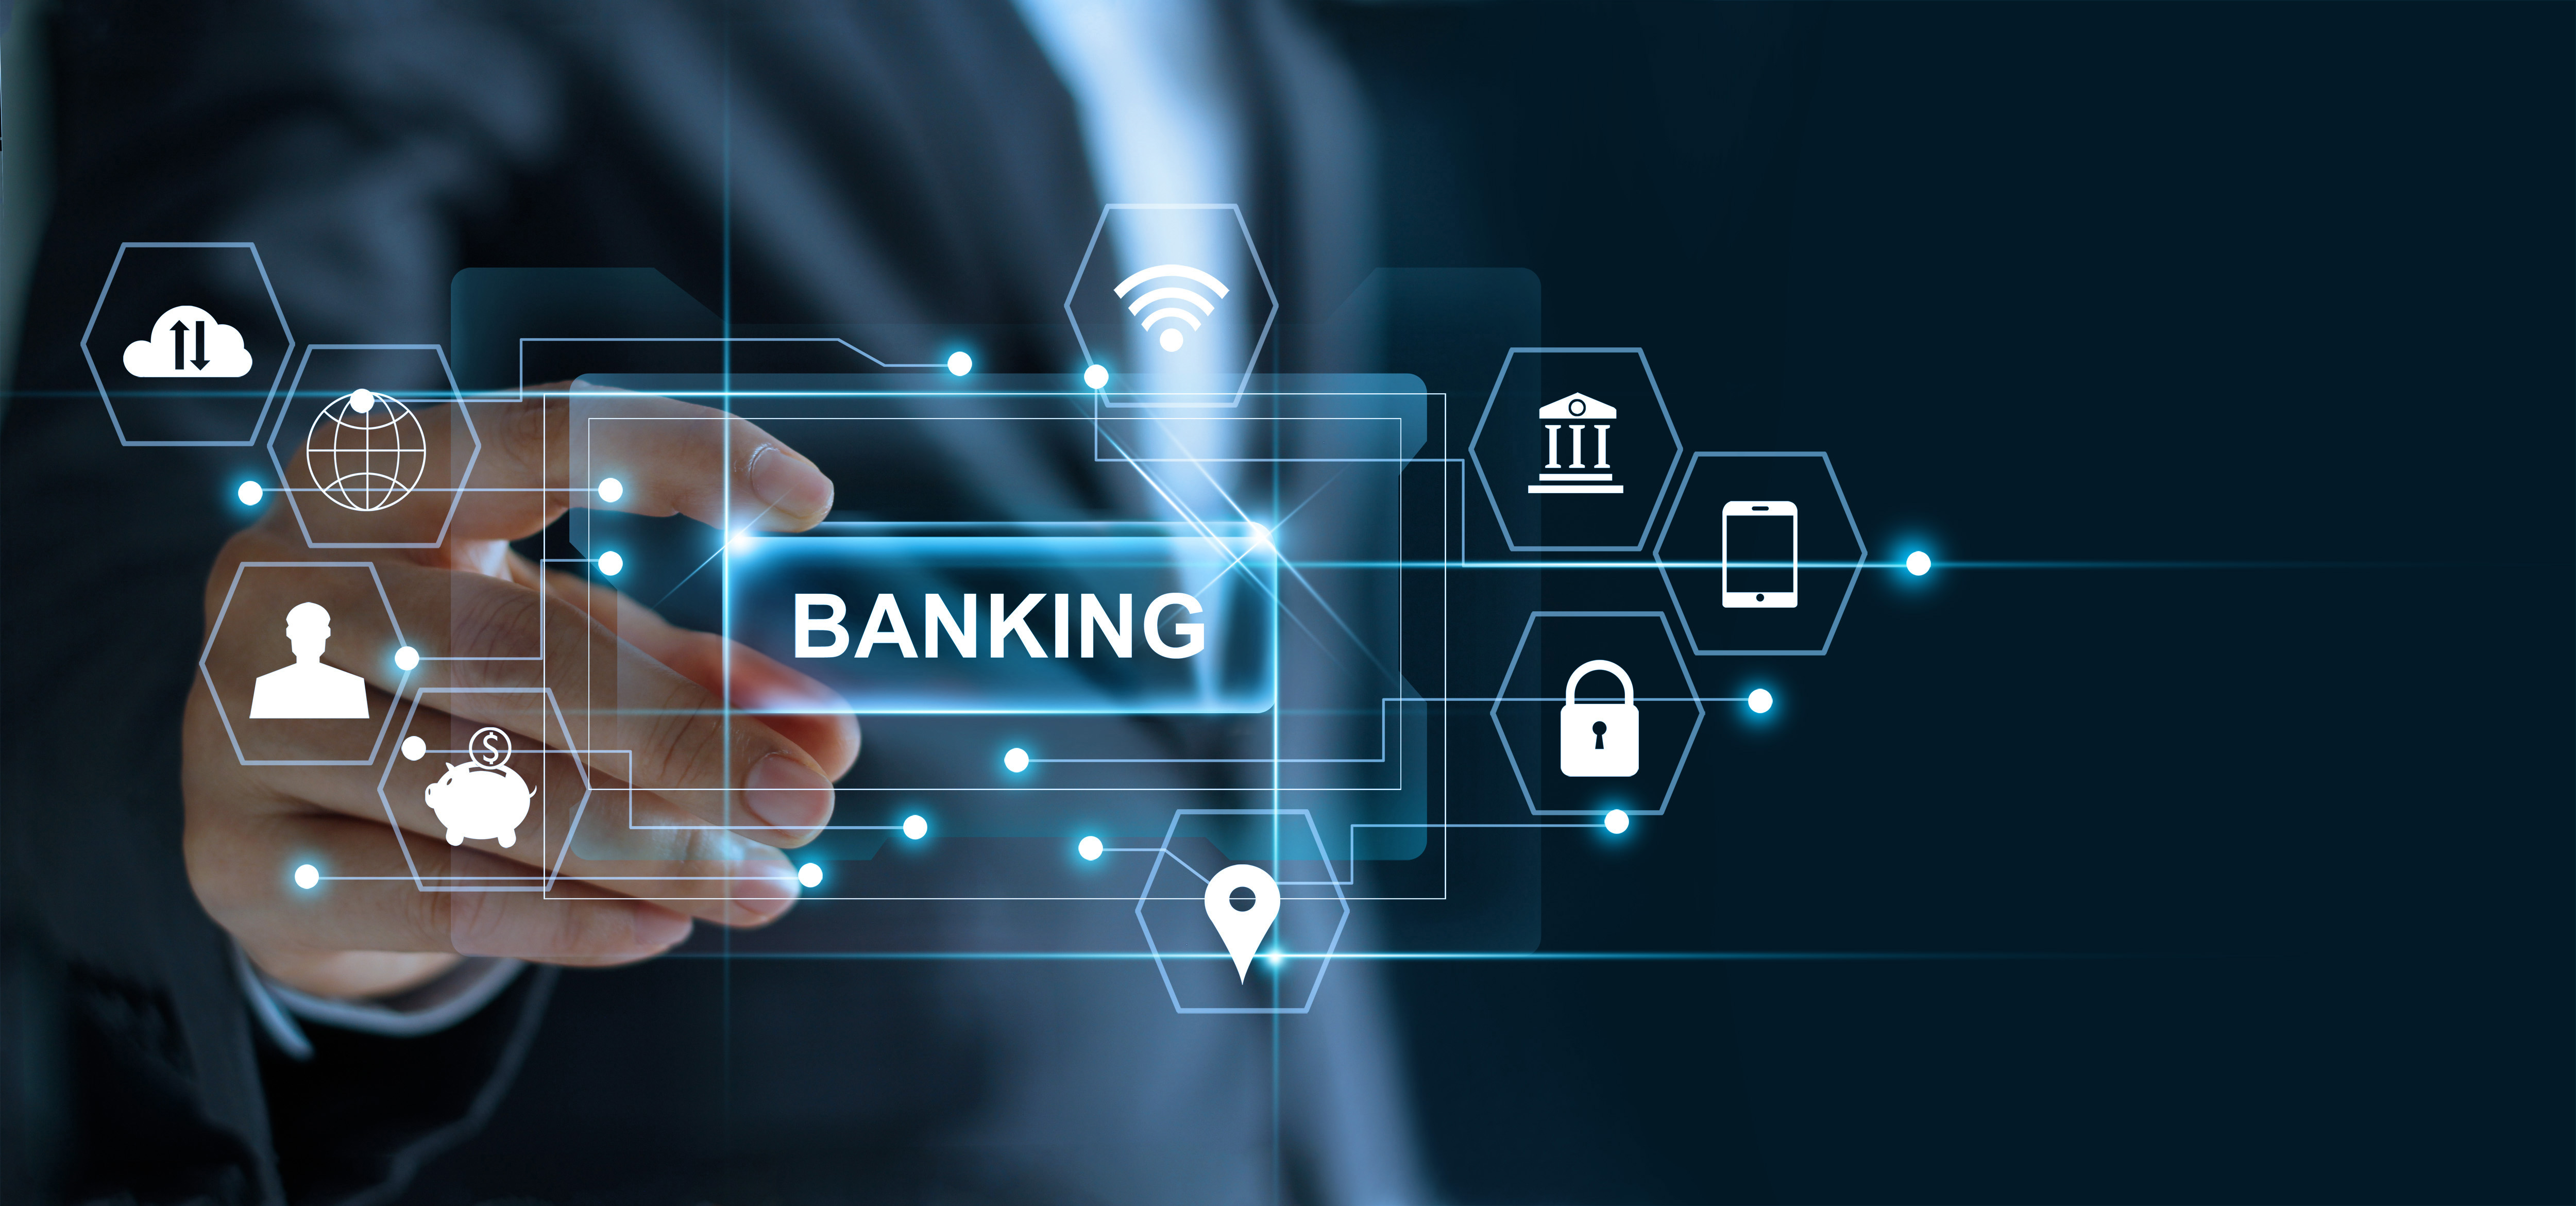


###  UDVAS DAS
#### MSc. in Big Data Ananlytics
#### RKMVERI, BELUR

# Importing the necessary libraries 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
from torch import nn
from torch.utils.data import DataLoader,TensorDataset,RandomSampler
sns.set(style="whitegrid")

# Reading the dataset
* Name of the dataset --- Bank-Marketing 
* Link to the .csv data file --- https://www.kaggle.com/datasets/sonujha090/bank-marketing?select=bank-full.csv
* We use Pandas package to read the data

# Dataset information
* Input variables:

## Bank client data:
* age (numeric)
* job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student",
"blue-collar","self-employed","retired","technician","services")
* marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)
* education (categorical: "unknown","secondary","primary","tertiary")
* default: has credit in default? (binary: "yes","no")
* balance: average yearly balance, in euros (numeric)
* housing: has housing loan? (binary: "yes","no")
* loan: has personal loan? (binary: "yes","no")

## Related with the last contact of the current campaign:
* contact: contact communication type (categorical: "unknown","telephone","cellular")
* day: last contact day of the month (numeric)
* month: last contact month of year (categorical: "jan", "feb", "mar", …, "nov", "dec")
* duration: last contact duration, in seconds (numeric)

## Other attributes:
* campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
* pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)
* previous: number of contacts performed before this campaign and for this client (numeric)
* poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")

## Output variable:
* y - has the client subscribed a term deposit? (binary: "yes","no")

In [2]:
path = '~/UDVAS DAS/bank-full.csv'
data = pd.read_csv(path)
data.head(5)

age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married    unknown      no     1506     yes   no   
4   33       unknown   single    unknown      no        1      no   no   

   contact  day month  duration  campaign  pdays  previous poutcome   y  
0  unknown    5   may       261         1     -1         0  unknown  no  
1  unknown    5   may       151         1     -1         0  unknown  no  
2  unknown    5   may        76         1     -1         0  unknown  no  
3  unknown    5   may        92         1     -1         0  unknown  no  
4  unknown    5   may       198         1     -1         0  unknown  no

Text(0.5, 1.0, 'Distribution of the outcome variable')

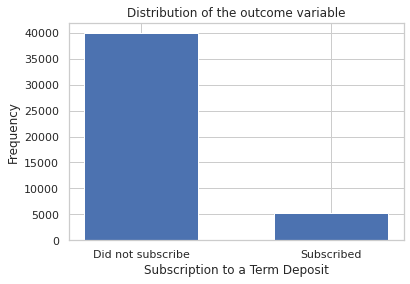

In [3]:
plt.bar(['Did not subscribe' , 'Subscribed'],list(data["y"].value_counts().values),width=0.6)
plt.xlabel("Subscription to a Term Deposit")
plt.ylabel("Frequency")
plt.title("Distribution of the outcome variable")

# Preprocessing the Data

* Dropping the 'month' and 'day' columns
* Label encoding the categorical variables and the outcome
* Creating the feature matrix
* Train-Test splitting 
* Normalizing the integer columns

In [4]:
outcome = data["y"]
df = data.drop(['y','month','day'],axis = 1)

In [5]:
label_encoder = LabelEncoder()
df.columns
encode_colnames = ['marital', 'education', 'default','housing',
       'loan', 'contact','poutcome']
for i in encode_colnames:
    df[i] = label_encoder.fit_transform(df[i])

In [6]:
uniq_cats = list(df['job'].unique())
df['job'] = df['job'].replace(uniq_cats,['employed','employed','employed','employed','unemployed','retired','employed',
                            'employed','self-employed','unemployed','unemployed','student'])
df['job'] = df['job'].replace(['unemployed','student','retired','self-employed','employed'],[1,2,3,4,5])

In [7]:
min_max_scaler = preprocessing.MinMaxScaler()
for i in ['age','duration','balance']:
    df[i] = min_max_scaler.fit_transform(np.array(df[i]).reshape(-1,1))

In [8]:
df.head(3)

age  job  marital  education  default   balance  housing  loan  \
0  0.519481    5        1          2        0  0.092259        1     0   
1  0.337662    5        2          1        0  0.073067        1     0   
2  0.194805    5        1          1        0  0.072822        1     1   

   contact  duration  campaign  pdays  previous  poutcome  
0        2  0.053070         1     -1         0         3  
1        2  0.030704         1     -1         0         3  
2        2  0.015453         1     -1         0         3

In [9]:
data = np.array(df)
y = np.array(outcome.replace(['yes','no'],[1,0]))

In [10]:
import random
random.seed(1000)

In [11]:
X_train, X_val_and_test, Y_train, Y_val_and_test = train_test_split(data, y, test_size=0.3)
X_val, X_test, Y_val, Y_test = train_test_split(X_val_and_test, Y_val_and_test, test_size=0.5)

In [12]:
print(X_train.shape, X_val.shape, X_test.shape, Y_train.shape, Y_val.shape, Y_test.shape)

(31647, 14) (6782, 14) (6782, 14) (31647,) (6782,) (6782,)


# Building the neural network

In [13]:
device = "cpu"
print(f"Using {device} device")

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(14,10),
            nn.ReLU(),
            nn.Linear(10,5),
            nn.ReLU(),
            nn.Linear(5,3)
        )
        self.sig = nn.Sigmoid()
        self.fc = nn.Linear(3,1)

    def forward(self, x):
        logits = self.fc(self.linear_relu_stack(x))
        logits = self.sig(logits)
        return logits

Using cpu device


In [14]:
loss_fn = nn.BCELoss()

# Training and Testing loop

In [15]:
def train(dataloader, model, loss_fn, optimizer):
    train_loss1 = []
    param_grad_norm = []
    param_grad = []
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        pred = model(X.float())
        loss = loss_fn(pred.view(X.shape[0]).float(),y.float())
        train_loss1.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        grad=0
        for i in model.parameters():
            param_grad_norm.append(torch.linalg.norm(i.grad.data).item())
            grad=i.grad.clone().detach().cpu().numpy()
            param_grad.append(grad)
    print("Training Loss = ",np.sum(train_loss1)/len(dataloader))
    return train_loss1,param_grad,param_grad_norm

In [16]:
def validation(dataloader,model,loss_fn):
    valid_loss1 = []
    valid_loss = 0.0
    min_val_loss = np.inf
    model.eval()
    for i, (data,label) in enumerate(dataloader):
        target = model(data.float())       
        loss = loss_fn(target.view(data.shape[0]).float(),label.float())
        valid_loss = loss.item()
        valid_loss1.append(valid_loss)
    print("\n Validation Loss = ",np.sum(valid_loss1)/len(dataloader))
    return np.mean(valid_loss1)

In [17]:
def test(dataloader,model,threshold):
    for i, (data,label) in enumerate(dataloader):
        outputs=(model(data.float())>threshold)
        accuracy=100*sum(label.detach().numpy()==outputs.detach().numpy().astype(int).squeeze())/X_test.shape[0]
    return accuracy

# Building the Dataclass

In [18]:
train_class = TensorDataset(torch.tensor(X_train),torch.tensor(Y_train))
test_class =  TensorDataset(torch.tensor(X_test),torch.tensor(Y_test))
val_class = TensorDataset(torch.tensor(X_val),torch.tensor(Y_val))

# GD

In [19]:
batch_size = X_train.shape[0]

train_dataloader = DataLoader(train_class, batch_size=batch_size)
test_dataloader = DataLoader(test_class, batch_size=X_test.shape[0])
val_dataloader = DataLoader(val_class, batch_size=X_val.shape[0])

In [20]:
model = NeuralNetwork().to(device)

In [21]:
optimizer = torch.optim.SGD(model.parameters(), lr=5e-3)

In [22]:
epochs = 300
train_losses = []
val_losses = []
pgrad = []
pgrad_norm = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss_print,param_grad,param_grad_norm =train(train_dataloader, model, loss_fn, optimizer)
    pgrad_norm.append(param_grad_norm[-2])
    pgrad.append(param_grad[-2])
    #print(param_grad[-2],"\n",param_grad_norm[-2])
    val_loss_print = validation(val_dataloader,model,loss_fn)
    train_losses.append(sum(train_loss_print)/len(train_loss_print))
    val_losses.append(val_loss_print)
    if val_loss_print<=np.min(val_losses):
        torch.save(model.state_dict(),'/home/sysadm/UDVAS DAS/model_GD.pt')
print("Done!")

Epoch 1
-------------------------------
Training Loss =  0.6552578806877136

 Validation Loss =  0.6263968348503113
Epoch 2
-------------------------------
Training Loss =  0.6338932514190674

 Validation Loss =  0.6110407710075378
Epoch 3
-------------------------------
Training Loss =  0.6186001300811768

 Validation Loss =  0.5968490839004517
Epoch 4
-------------------------------
Training Loss =  0.6044861078262329

 Validation Loss =  0.5834992527961731
Epoch 5
-------------------------------
Training Loss =  0.5912159085273743

 Validation Loss =  0.5709100961685181
Epoch 6
-------------------------------
Training Loss =  0.5787013173103333

 Validation Loss =  0.5590342283248901
Epoch 7
-------------------------------
Training Loss =  0.5668986439704895

 Validation Loss =  0.5478391051292419
Epoch 8
-------------------------------
Training Loss =  0.5557689070701599

 Validation Loss =  0.5372946858406067
Epoch 9
-------------------------------
Training Loss =  0.5452843904495

Training Loss =  0.41808390617370605

 Validation Loss =  0.40830808877944946
Epoch 72
-------------------------------
Training Loss =  0.41736307740211487

 Validation Loss =  0.4075605273246765
Epoch 73
-------------------------------
Training Loss =  0.4166468679904938

 Validation Loss =  0.4068175256252289
Epoch 74
-------------------------------
Training Loss =  0.415935218334198

 Validation Loss =  0.40607908368110657
Epoch 75
-------------------------------
Training Loss =  0.4152282178401947

 Validation Loss =  0.40534526109695435
Epoch 76
-------------------------------
Training Loss =  0.4145258963108063

 Validation Loss =  0.40461596846580505
Epoch 77
-------------------------------
Training Loss =  0.41382819414138794

 Validation Loss =  0.403891384601593
Epoch 78
-------------------------------
Training Loss =  0.4131350815296173

 Validation Loss =  0.40317127108573914
Epoch 79
-------------------------------
Training Loss =  0.41244664788246155

 Validation Loss =  

Training Loss =  0.3791077136993408

 Validation Loss =  0.3673911690711975
Epoch 142
-------------------------------
Training Loss =  0.37871482968330383

 Validation Loss =  0.366970419883728
Epoch 143
-------------------------------
Training Loss =  0.3783261477947235

 Validation Loss =  0.36655393242836
Epoch 144
-------------------------------
Training Loss =  0.37794169783592224

 Validation Loss =  0.3661414682865143
Epoch 145
-------------------------------
Training Loss =  0.3775613605976105

 Validation Loss =  0.3657333552837372
Epoch 146
-------------------------------
Training Loss =  0.37718522548675537

 Validation Loss =  0.3653293251991272
Epoch 147
-------------------------------
Training Loss =  0.3768131732940674

 Validation Loss =  0.3649294972419739
Epoch 148
-------------------------------
Training Loss =  0.37644529342651367

 Validation Loss =  0.36453384160995483
Epoch 149
-------------------------------
Training Loss =  0.3760813772678375

 Validation Loss 

Training Loss =  0.3604550063610077

 Validation Loss =  0.3469531238079071
Epoch 211
-------------------------------
Training Loss =  0.360287606716156

 Validation Loss =  0.3467627763748169
Epoch 212
-------------------------------
Training Loss =  0.3601224720478058

 Validation Loss =  0.3465748131275177
Epoch 213
-------------------------------
Training Loss =  0.3599597215652466

 Validation Loss =  0.34638911485671997
Epoch 214
-------------------------------
Training Loss =  0.35979941487312317

 Validation Loss =  0.34620580077171326
Epoch 215
-------------------------------
Training Loss =  0.35964131355285645

 Validation Loss =  0.3460247218608856
Epoch 216
-------------------------------
Training Loss =  0.35948535799980164

 Validation Loss =  0.3458459973335266
Epoch 217
-------------------------------
Training Loss =  0.3593316078186035

 Validation Loss =  0.34566956758499146
Epoch 218
-------------------------------
Training Loss =  0.3591799736022949

 Validation Lo

Training Loss =  0.35299092531204224

 Validation Loss =  0.33810603618621826
Epoch 281
-------------------------------
Training Loss =  0.35293006896972656

 Validation Loss =  0.3380291163921356
Epoch 282
-------------------------------
Training Loss =  0.3528701364994049

 Validation Loss =  0.3379531800746918
Epoch 283
-------------------------------
Training Loss =  0.3528110384941101

 Validation Loss =  0.3378782272338867
Epoch 284
-------------------------------
Training Loss =  0.3527528643608093

 Validation Loss =  0.3378043472766876
Epoch 285
-------------------------------
Training Loss =  0.35269561409950256

 Validation Loss =  0.33773136138916016
Epoch 286
-------------------------------
Training Loss =  0.3526391386985779

 Validation Loss =  0.3376593589782715
Epoch 287
-------------------------------
Training Loss =  0.3525835871696472

 Validation Loss =  0.3375883102416992
Epoch 288
-------------------------------
Training Loss =  0.352528840303421

 Validation Los

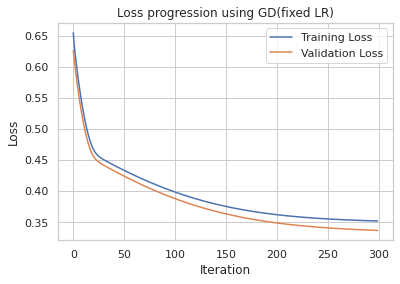

In [23]:
plt.plot(train_losses)
plt.plot(val_losses)
plt.title("Loss progression using GD(fixed LR)")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend(["Training Loss","Validation Loss"])

In [24]:
acc=[]
for i in np.linspace(0.1,1,50):
    acc.append(test(test_dataloader,model,i))

Text(0.5, 1.0, 'Threshold vs Accuracy')

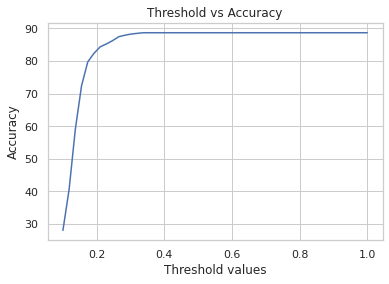

In [25]:
plt.plot(np.linspace(0.1,1,50),acc)
plt.xlabel("Threshold values")
plt.ylabel("Accuracy")
plt.title("Threshold vs Accuracy")

In [26]:
print("The best threshold is --- ",np.linspace(0.1,1,50)[np.argmax(acc)])

The best threshold is ---  0.3387755102040817


In [27]:
print("The best accuracy we can achieve using GD with constant LR is --- ",acc[np.argmax(acc)])

The best accuracy we can achieve using GD with constant LR is ---  88.6611618991448


In [28]:
gradient_dot = []
for i in range(len(pgrad)-1):
    gradient_dot.append(np.squeeze(np.dot(pgrad[i],pgrad[i+1].T)/(pgrad_norm[i]*pgrad_norm[i+1])))

Text(0.5, 0, 'Iteration')

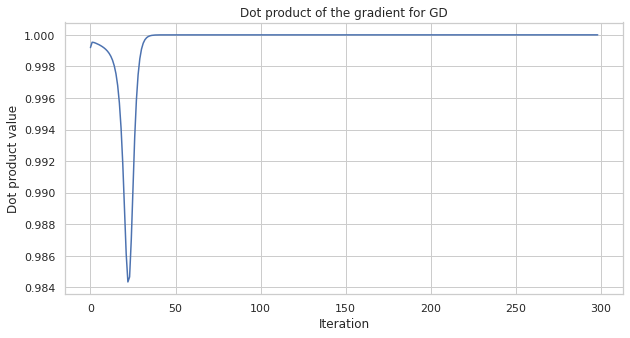

In [29]:
plt.figure(figsize=(10,5))
plt.plot(gradient_dot)
#plt.yticks([0.0025,0,-0.0025])
plt.title("Dot product of the gradient for GD")
plt.ylabel("Dot product value")
plt.xlabel("Iteration")

### Need to do a scatter plot, so that we can capture the direction of the gradient

Text(0.5, 0, 'Gradient norm value')

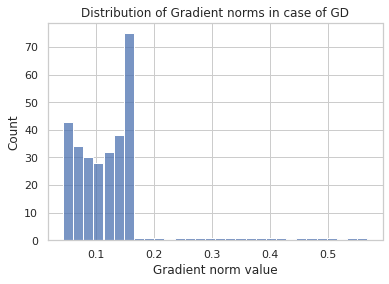

In [30]:
sns.histplot(pgrad_norm,fill=True,bins=30)
plt.title("Distribution of Gradient norms in case of GD")
plt.xlabel("Gradient norm value")

# SGD

In [106]:
model1 = NeuralNetwork().to(device)

In [107]:
batch_size = 1

train_dataloader = DataLoader(train_class, batch_size=batch_size,  sampler=RandomSampler(X_train))
test_dataloader = DataLoader(test_class, batch_size=X_test.shape[0])
val_dataloader = DataLoader(val_class, batch_size=X_val.shape[0])

In [108]:
optimizer1 = torch.optim.SGD(model1.parameters(), lr=5e-3)

In [109]:
epochs = 100
train_losses = []
val_losses = []
pgrad = []
pgrad_norm = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss_print,param_grad,param_grad_norm =train(train_dataloader, model1, loss_fn, optimizer1)
    pgrad_norm.append(param_grad_norm[-2])
    pgrad.append(param_grad[-2])
    #print(param_grad[-2],"\n",param_grad_norm[-2])
    val_loss_print = validation(val_dataloader,model1,loss_fn)
    train_losses.append(sum(train_loss_print)/len(train_loss_print))
    val_losses.append(val_loss_print)
    if val_loss_print<=np.min(val_losses):
        torch.save(model.state_dict(),'/home/sysadm/UDVAS DAS/model_SGD.pt')
print("Done!")

Epoch 1
-------------------------------
Training Loss =  0.3468076098027566

 Validation Loss =  0.3264849781990051
Epoch 2
-------------------------------
Training Loss =  0.33909323249564993

 Validation Loss =  0.32342272996902466
Epoch 3
-------------------------------
Training Loss =  0.3363683440621655

 Validation Loss =  0.33260607719421387
Epoch 4
-------------------------------
Training Loss =  0.33282594176678115

 Validation Loss =  0.317177951335907
Epoch 5
-------------------------------
Training Loss =  0.3276004993305546

 Validation Loss =  0.35885506868362427
Epoch 6
-------------------------------
Training Loss =  0.32352558014965593

 Validation Loss =  0.3068263530731201
Epoch 7
-------------------------------
Training Loss =  0.31817560738149864

 Validation Loss =  0.31824755668640137
Epoch 8
-------------------------------
Training Loss =  0.3105668539753534

 Validation Loss =  0.2912016808986664
Epoch 9
-------------------------------
Training Loss =  0.306276

Training Loss =  0.2757948922197061

 Validation Loss =  0.27263709902763367
Epoch 72
-------------------------------
Training Loss =  0.2751904108381781

 Validation Loss =  0.2742008566856384
Epoch 73
-------------------------------
Training Loss =  0.2752745769710428

 Validation Loss =  0.27318620681762695
Epoch 74
-------------------------------
Training Loss =  0.27542027762249904

 Validation Loss =  0.27390849590301514
Epoch 75
-------------------------------
Training Loss =  0.2745711551998032

 Validation Loss =  0.27825209498405457
Epoch 76
-------------------------------
Training Loss =  0.2745728232736359

 Validation Loss =  0.28691065311431885
Epoch 77
-------------------------------
Training Loss =  0.2743608200590006

 Validation Loss =  0.27335473895072937
Epoch 78
-------------------------------
Training Loss =  0.2750827083127224

 Validation Loss =  0.2717839479446411
Epoch 79
-------------------------------
Training Loss =  0.27438692476752896

 Validation Loss = 

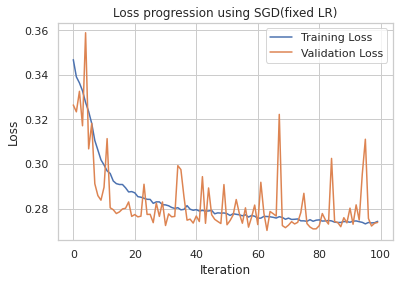

In [110]:
plt.plot(train_losses)
plt.plot(val_losses)
plt.title("Loss progression using SGD(fixed LR)")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend(["Training Loss","Validation Loss"])

In [111]:
acc1=[]
for i in np.linspace(0.1,1,50):
    acc1.append(test(test_dataloader,model1,i))

Text(0.5, 1.0, 'Threshold vs Accuracy')

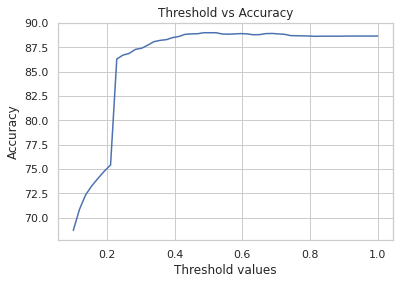

In [112]:
plt.plot(np.linspace(0.1,1,50),acc1)
plt.xlabel("Threshold values")
plt.ylabel("Accuracy")
plt.title("Threshold vs Accuracy")

In [113]:
print("The best threshold is --- ",np.linspace(0.1,1,50)[np.argmax(acc1)])

The best threshold is ---  0.48571428571428577


In [114]:
print("The best accuracy we can achieve using SGD with constant LR is --- ",acc1[np.argmax(acc1)])

The best accuracy we can achieve using SGD with constant LR is ---  89.0002948982601


In [115]:
gradient_dot1 = []
for i in range(len(pgrad)-1):
    gradient_dot1.append(np.squeeze(np.dot(pgrad[i],pgrad[i+1].T)/(pgrad_norm[i]*pgrad_norm[i+1])))

Text(0.5, 0, 'Iteration')

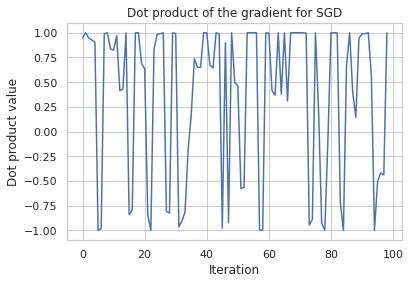

In [116]:
plt.plot(gradient_dot1)
#plt.yticks([.12,0.0,-.12])
plt.title("Dot product of the gradient for SGD")
plt.ylabel("Dot product value")
plt.xlabel("Iteration")

Text(0.5, 0, 'Gradient norm value')

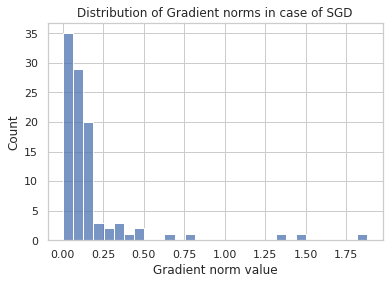

In [117]:
sns.histplot(pgrad_norm,fill=True,bins=30)
plt.title("Distribution of Gradient norms in case of SGD")
plt.xlabel("Gradient norm value")

# SGD (Minibatching)

In [43]:
model2 = NeuralNetwork().to(device)

In [44]:
batch_size = 64

train_dataloader = DataLoader(train_class, batch_size=batch_size, sampler = RandomSampler(X_train))
test_dataloader = DataLoader(test_class, batch_size=X_test.shape[0])
val_dataloader = DataLoader(val_class, batch_size=X_val.shape[0])

In [45]:
optimizer2 = torch.optim.SGD(model2.parameters(), lr=5e-3)

In [46]:
epochs = 300
train_losses = []
val_losses = []
pgrad = []
pgrad_norm = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss_print,param_grad,param_grad_norm =train(train_dataloader, model2, loss_fn, optimizer2)
    pgrad_norm.append(param_grad_norm[-2])
    pgrad.append(param_grad[-2])
    #print(param_grad[-2],"\n",param_grad_norm[-2])
    val_loss_print = validation(val_dataloader,model2,loss_fn)
    train_losses.append(sum(train_loss_print)/len(train_loss_print))
    val_losses.append(val_loss_print)
    if val_loss_print<=np.min(val_losses):
        torch.save(model.state_dict(),'/home/sysadm/UDVAS DAS/model_SGD(Mini).pt')
print("Done!")

Epoch 1
-------------------------------
Training Loss =  0.3998063467969798

 Validation Loss =  0.3340676724910736
Epoch 2
-------------------------------
Training Loss =  0.34925664308095217

 Validation Loss =  0.33152511715888977
Epoch 3
-------------------------------
Training Loss =  0.3479945854406164

 Validation Loss =  0.33433693647384644
Epoch 4
-------------------------------
Training Loss =  0.34700413846006295

 Validation Loss =  0.33168959617614746
Epoch 5
-------------------------------
Training Loss =  0.3460687798984123

 Validation Loss =  0.32890552282333374
Epoch 6
-------------------------------
Training Loss =  0.3454269002182315

 Validation Loss =  0.3287203311920166
Epoch 7
-------------------------------
Training Loss =  0.34498072116061895

 Validation Loss =  0.32817819714546204
Epoch 8
-------------------------------
Training Loss =  0.34409663692267256

 Validation Loss =  0.33049967885017395
Epoch 9
-------------------------------
Training Loss =  0.343

Training Loss =  0.33064789925560806

 Validation Loss =  0.3177332580089569
Epoch 72
-------------------------------
Training Loss =  0.33017571204238466

 Validation Loss =  0.317482054233551
Epoch 73
-------------------------------
Training Loss =  0.3299215903185835

 Validation Loss =  0.3206198811531067
Epoch 74
-------------------------------
Training Loss =  0.33063894034636143

 Validation Loss =  0.3296820819377899
Epoch 75
-------------------------------
Training Loss =  0.3299854179524412

 Validation Loss =  0.33036917448043823
Epoch 76
-------------------------------
Training Loss =  0.33024844542296244

 Validation Loss =  0.31981542706489563
Epoch 77
-------------------------------
Training Loss =  0.33020110043010326

 Validation Loss =  0.32327842712402344
Epoch 78
-------------------------------
Training Loss =  0.32976792234965047

 Validation Loss =  0.3153022527694702
Epoch 79
-------------------------------
Training Loss =  0.3286700220421107

 Validation Loss = 

Training Loss =  0.2900128734984783

 Validation Loss =  0.28743481636047363
Epoch 142
-------------------------------
Training Loss =  0.28814168256340605

 Validation Loss =  0.29089683294296265
Epoch 143
-------------------------------
Training Loss =  0.28969403986979014

 Validation Loss =  0.2814851701259613
Epoch 144
-------------------------------
Training Loss =  0.2875206592257577

 Validation Loss =  0.2757300138473511
Epoch 145
-------------------------------
Training Loss =  0.28729691186336553

 Validation Loss =  0.28241148591041565
Epoch 146
-------------------------------
Training Loss =  0.2798714966484995

 Validation Loss =  0.2837661802768707
Epoch 147
-------------------------------
Training Loss =  0.28193915396025687

 Validation Loss =  0.2837860882282257
Epoch 148
-------------------------------
Training Loss =  0.28319737959389735

 Validation Loss =  0.2837323844432831
Epoch 149
-------------------------------
Training Loss =  0.28471470339731736

 Validatio

Training Loss =  0.28454496175652805

 Validation Loss =  0.2840448319911957
Epoch 211
-------------------------------
Training Loss =  0.2841479432402235

 Validation Loss =  0.2786449193954468
Epoch 212
-------------------------------
Training Loss =  0.2838626160465106

 Validation Loss =  0.28486576676368713
Epoch 213
-------------------------------
Training Loss =  0.28356558377995633

 Validation Loss =  0.29247695207595825
Epoch 214
-------------------------------
Training Loss =  0.284078615828596

 Validation Loss =  0.30315282940864563
Epoch 215
-------------------------------
Training Loss =  0.283159864791716

 Validation Loss =  0.28033822774887085
Epoch 216
-------------------------------
Training Loss =  0.2837381132022299

 Validation Loss =  0.32510754466056824
Epoch 217
-------------------------------
Training Loss =  0.2845722053087119

 Validation Loss =  0.2788616716861725
Epoch 218
-------------------------------
Training Loss =  0.2831303954726518

 Validation Lo

Training Loss =  0.28195663591225945

 Validation Loss =  0.2781175673007965
Epoch 281
-------------------------------
Training Loss =  0.28183803538782426

 Validation Loss =  0.2819005846977234
Epoch 282
-------------------------------
Training Loss =  0.28248364841095125

 Validation Loss =  0.2764717936515808
Epoch 283
-------------------------------
Training Loss =  0.2821926394797335

 Validation Loss =  0.27771127223968506
Epoch 284
-------------------------------
Training Loss =  0.2815844392686179

 Validation Loss =  0.3005390763282776
Epoch 285
-------------------------------
Training Loss =  0.2815246184967985

 Validation Loss =  0.2861545979976654
Epoch 286
-------------------------------
Training Loss =  0.2814496621489525

 Validation Loss =  0.2803283631801605
Epoch 287
-------------------------------
Training Loss =  0.28255957328911985

 Validation Loss =  0.27720263600349426
Epoch 288
-------------------------------
Training Loss =  0.2816269786520438

 Validation L

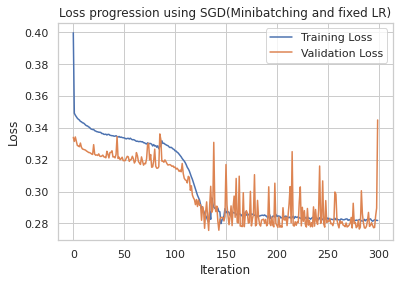

In [47]:
plt.plot(train_losses)
plt.plot(val_losses)
plt.title("Loss progression using SGD(Minibatching and fixed LR)")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend(["Training Loss","Validation Loss"])

In [48]:
acc2=[]
for i in np.linspace(0.1,1,50):
    acc2.append(test(test_dataloader,model2,i))

Text(0.5, 1.0, 'Threshold vs Accuracy')

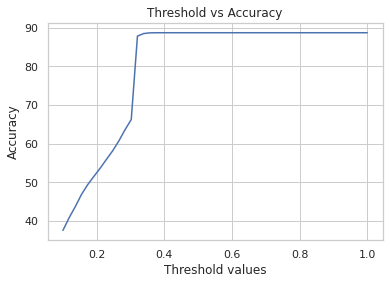

In [49]:
plt.plot(np.linspace(0.1,1,50),acc2)
plt.xlabel("Threshold values")
plt.ylabel("Accuracy")
plt.title("Threshold vs Accuracy")

In [50]:
print("The best threshold is --- ",np.linspace(0.1,1,50)[np.argmax(acc2)])

The best threshold is ---  0.3755102040816327


In [51]:
print("The best accuracy we can achieve using SGD(Minibatching) with constant LR is --- ",acc2[np.argmax(acc2)])

The best accuracy we can achieve using SGD(Minibatching) with constant LR is ---  88.6611618991448


In [52]:
gradient_dot2 = []
for i in range(len(pgrad)-1):
    gradient_dot2.append(np.squeeze(np.dot(pgrad[i],pgrad[i+1].T)/(pgrad_norm[i]*pgrad_norm[i+1])))

Text(0.5, 0, 'Gradient')

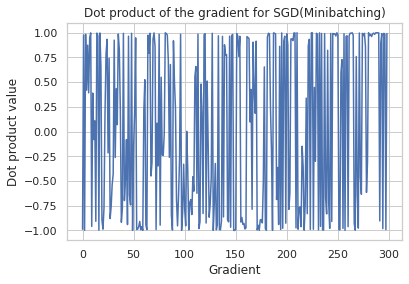

In [53]:
plt.plot(gradient_dot2)
#plt.yticks([1.2,0.0,-1.2])
plt.title("Dot product of the gradient for SGD(Minibatching)")
plt.ylabel("Dot product value")
plt.xlabel("Gradient")

Text(0.5, 0, 'Gradient norm value')

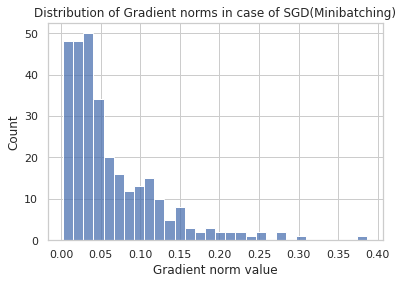

In [54]:
sns.histplot(pgrad_norm,fill=True,bins=30)
plt.title("Distribution of Gradient norms in case of SGD(Minibatching)")
plt.xlabel("Gradient norm value")

# ASGD

In [55]:
model3 = NeuralNetwork().to(device)

In [56]:
batch_size = 64

train_dataloader = DataLoader(train_class, batch_size=batch_size, sampler = RandomSampler(X_train))
test_dataloader = DataLoader(test_class, batch_size=X_test.shape[0])
val_dataloader = DataLoader(val_class, batch_size=X_val.shape[0])

In [57]:
optimizer3 = torch.optim.ASGD(model3.parameters(), lr=5e-3)

In [58]:
epochs = 300
train_losses = []
val_losses = []
pgrad = []
pgrad_norm = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss_print,param_grad,param_grad_norm =train(train_dataloader, model3, loss_fn, optimizer3)
    pgrad_norm.append(param_grad_norm[-2])
    pgrad.append(param_grad[-2])
    #print(param_grad[-2],"\n",param_grad_norm[-2])
    val_loss_print = validation(val_dataloader,model3,loss_fn)
    train_losses.append(sum(train_loss_print)/len(train_loss_print))
    val_losses.append(val_loss_print)
    if val_loss_print<=np.min(val_losses):
        torch.save(model.state_dict(),'/home/sysadm/UDVAS DAS/model_ASGD.pt')
print("Done!")

Epoch 1
-------------------------------
Training Loss =  0.47643624532102336

 Validation Loss =  0.4154748320579529
Epoch 2
-------------------------------
Training Loss =  0.40109998252656726

 Validation Loss =  0.3752460479736328
Epoch 3
-------------------------------
Training Loss =  0.3760597239841114

 Validation Loss =  0.35853251814842224
Epoch 4
-------------------------------
Training Loss =  0.3661140782965554

 Validation Loss =  0.351583331823349
Epoch 5
-------------------------------
Training Loss =  0.36205954018867376

 Validation Loss =  0.34834083914756775
Epoch 6
-------------------------------
Training Loss =  0.36024590721636107

 Validation Loss =  0.3467903137207031
Epoch 7
-------------------------------
Training Loss =  0.3595551909521373

 Validation Loss =  0.3459694981575012
Epoch 8
-------------------------------
Training Loss =  0.3591528178465487

 Validation Loss =  0.3454611003398895
Epoch 9
-------------------------------
Training Loss =  0.35893621

Training Loss =  0.3345553135932094

 Validation Loss =  0.31479141116142273
Epoch 72
-------------------------------
Training Loss =  0.33340065145131315

 Validation Loss =  0.32915499806404114
Epoch 73
-------------------------------
Training Loss =  0.3328407813202251

 Validation Loss =  0.31441929936408997
Epoch 74
-------------------------------
Training Loss =  0.3335674830759415

 Validation Loss =  0.31717440485954285
Epoch 75
-------------------------------
Training Loss =  0.3339759498232543

 Validation Loss =  0.32535800337791443
Epoch 76
-------------------------------
Training Loss =  0.3311656626487019

 Validation Loss =  0.31311941146850586
Epoch 77
-------------------------------
Training Loss =  0.3318007147372371

 Validation Loss =  0.3460657596588135
Epoch 78
-------------------------------
Training Loss =  0.33560911028674156

 Validation Loss =  0.3214653730392456
Epoch 79
-------------------------------
Training Loss =  0.3313964143846974

 Validation Loss = 

Training Loss =  0.3127548080050584

 Validation Loss =  0.38267940282821655
Epoch 142
-------------------------------
Training Loss =  0.31236474816546295

 Validation Loss =  0.2993386387825012
Epoch 143
-------------------------------
Training Loss =  0.3119024196808988

 Validation Loss =  0.30704787373542786
Epoch 144
-------------------------------
Training Loss =  0.31382973900046013

 Validation Loss =  0.3028008043766022
Epoch 145
-------------------------------
Training Loss =  0.3104605406522751

 Validation Loss =  0.3007073998451233
Epoch 146
-------------------------------
Training Loss =  0.30903241992598834

 Validation Loss =  0.2968140244483948
Epoch 147
-------------------------------
Training Loss =  0.3199703181181291

 Validation Loss =  0.2987684905529022
Epoch 148
-------------------------------
Training Loss =  0.3058994634584947

 Validation Loss =  0.29512226581573486
Epoch 149
-------------------------------
Training Loss =  0.30531976146228385

 Validation 

Training Loss =  0.28488498569437953

 Validation Loss =  0.2958161532878876
Epoch 211
-------------------------------
Training Loss =  0.2848415267738429

 Validation Loss =  0.27785974740982056
Epoch 212
-------------------------------
Training Loss =  0.2767458309127827

 Validation Loss =  0.2753086984157562
Epoch 213
-------------------------------
Training Loss =  0.27805179691675935

 Validation Loss =  0.2725115716457367
Epoch 214
-------------------------------
Training Loss =  0.2782271431853073

 Validation Loss =  0.2812289297580719
Epoch 215
-------------------------------
Training Loss =  0.2749901578131348

 Validation Loss =  0.27522870898246765
Epoch 216
-------------------------------
Training Loss =  0.2763824654347969

 Validation Loss =  0.2724624276161194
Epoch 217
-------------------------------
Training Loss =  0.274527476050637

 Validation Loss =  0.26864442229270935
Epoch 218
-------------------------------
Training Loss =  0.2748299435383142

 Validation Los

Training Loss =  0.27333390435787164

 Validation Loss =  0.28156372904777527
Epoch 280
-------------------------------
Training Loss =  0.2703310418761138

 Validation Loss =  0.2712613642215729
Epoch 281
-------------------------------
Training Loss =  0.27109373583637103

 Validation Loss =  0.28264379501342773
Epoch 282
-------------------------------
Training Loss =  0.2720141634796605

 Validation Loss =  0.26861652731895447
Epoch 283
-------------------------------
Training Loss =  0.2721028240943196

 Validation Loss =  0.27428147196769714
Epoch 284
-------------------------------
Training Loss =  0.2707968756405994

 Validation Loss =  0.30638831853866577
Epoch 285
-------------------------------
Training Loss =  0.27201490009372886

 Validation Loss =  0.27343425154685974
Epoch 286
-------------------------------
Training Loss =  0.2713140116044969

 Validation Loss =  0.26684755086898804
Epoch 287
-------------------------------
Training Loss =  0.27023632353303406

 Validat

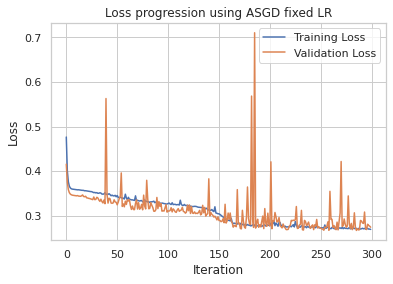

In [59]:
plt.plot(train_losses)
plt.plot(val_losses)
plt.title("Loss progression using ASGD fixed LR")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend(["Training Loss","Validation Loss"])

In [60]:
acc3=[]
for i in np.linspace(0.1,1,50):
    acc3.append(test(test_dataloader,model3,i))

Text(0.5, 1.0, 'Threshold vs Accuracy')

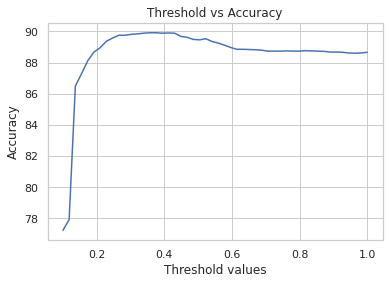

In [61]:
plt.plot(np.linspace(0.1,1,50),acc3)
plt.xlabel("Threshold values")
plt.ylabel("Accuracy")
plt.title("Threshold vs Accuracy")

In [62]:
print("The best threshold is --- ",np.linspace(0.1,1,50)[np.argmax(acc3)])
print("The best accuracy we can achieve using ASGD with constant LR is --- ",acc3[np.argmax(acc3)])

The best threshold is ---  0.3571428571428572
The best accuracy we can achieve using ASGD with constant LR is ---  89.91447950457092


In [63]:
gradient_dot3 = []
for i in range(len(pgrad)-1):
    gradient_dot3.append(np.squeeze(np.dot(pgrad[i],pgrad[i+1].T)/(pgrad_norm[i]*pgrad_norm[i+1])))

Text(0.5, 0, 'Gradient')

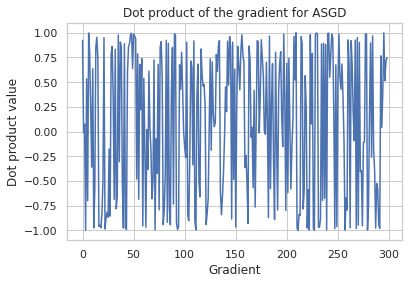

In [64]:
plt.plot(gradient_dot3)
#plt.yticks([1.2,0.0,-1.2])
plt.title("Dot product of the gradient for ASGD")
plt.ylabel("Dot product value")
plt.xlabel("Gradient")

Text(0.5, 0, 'Gradient norm value')

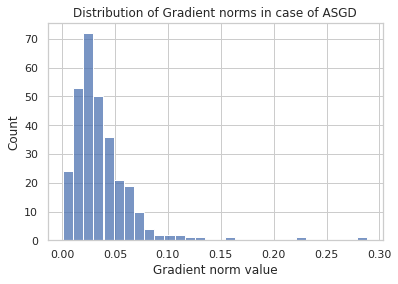

In [65]:
sns.histplot(pgrad_norm,fill=True,bins=30)
plt.title("Distribution of Gradient norms in case of ASGD")
plt.xlabel("Gradient norm value")

# ADAM

In [66]:
model4 = NeuralNetwork().to(device)

In [67]:
batch_size = 64

train_dataloader = DataLoader(train_class, batch_size=batch_size, sampler = RandomSampler(X_train))
test_dataloader = DataLoader(test_class, batch_size=X_test.shape[0])
val_dataloader = DataLoader(val_class, batch_size=X_val.shape[0])

In [68]:
optimizer4 = torch.optim.Adam(model4.parameters(), lr=5e-3)

In [69]:
epochs = 300
train_losses = []
val_losses = []
pgrad = []
pgrad_norm = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss_print,param_grad,param_grad_norm =train(train_dataloader, model4, loss_fn, optimizer4)
    pgrad_norm.append(param_grad_norm[-2])
    pgrad.append(param_grad[-2])
    #print(param_grad[-2],"\n",param_grad_norm[-2])
    val_loss_print = validation(val_dataloader,model4,loss_fn)
    train_losses.append(sum(train_loss_print)/len(train_loss_print))
    val_losses.append(val_loss_print)
    if val_loss_print<=np.min(val_losses):
        torch.save(model.state_dict(),'/home/sysadm/UDVAS DAS/model_ADAM.pt')
print("Done!")

Epoch 1
-------------------------------
Training Loss =  0.33729694201187654

 Validation Loss =  0.29928866028785706
Epoch 2
-------------------------------
Training Loss =  0.28595914229600117

 Validation Loss =  0.2758803963661194
Epoch 3
-------------------------------
Training Loss =  0.27848121027151745

 Validation Loss =  0.30906108021736145
Epoch 4
-------------------------------
Training Loss =  0.2740731258584995

 Validation Loss =  0.27563145756721497
Epoch 5
-------------------------------
Training Loss =  0.2742278392417262

 Validation Loss =  0.272407203912735
Epoch 6
-------------------------------
Training Loss =  0.27247565804105817

 Validation Loss =  0.27979594469070435
Epoch 7
-------------------------------
Training Loss =  0.2740268185584232

 Validation Loss =  0.272992879152298
Epoch 8
-------------------------------
Training Loss =  0.2715613577251482

 Validation Loss =  0.27096572518348694
Epoch 9
-------------------------------
Training Loss =  0.272918

Training Loss =  0.265660333347441

 Validation Loss =  0.2682071626186371
Epoch 72
-------------------------------
Training Loss =  0.26507523079412154

 Validation Loss =  0.2700560986995697
Epoch 73
-------------------------------
Training Loss =  0.2644300178897501

 Validation Loss =  0.27030086517333984
Epoch 74
-------------------------------
Training Loss =  0.26511895533161933

 Validation Loss =  0.2707577645778656
Epoch 75
-------------------------------
Training Loss =  0.26540630169288076

 Validation Loss =  0.2675718665122986
Epoch 76
-------------------------------
Training Loss =  0.26463936215097256

 Validation Loss =  0.2697201669216156
Epoch 77
-------------------------------
Training Loss =  0.2647942588034302

 Validation Loss =  0.2715633511543274
Epoch 78
-------------------------------
Training Loss =  0.2644656488540197

 Validation Loss =  0.26812711358070374
Epoch 79
-------------------------------
Training Loss =  0.26491879501728094

 Validation Loss =  0

Training Loss =  0.26330448709654086

 Validation Loss =  0.26887208223342896
Epoch 142
-------------------------------
Training Loss =  0.2633217453956604

 Validation Loss =  0.2687720060348511
Epoch 143
-------------------------------
Training Loss =  0.2628212639629239

 Validation Loss =  0.26827216148376465
Epoch 144
-------------------------------
Training Loss =  0.2629726767539978

 Validation Loss =  0.271013081073761
Epoch 145
-------------------------------
Training Loss =  0.2628164433921226

 Validation Loss =  0.270645409822464
Epoch 146
-------------------------------
Training Loss =  0.2633251753118303

 Validation Loss =  0.26799723505973816
Epoch 147
-------------------------------
Training Loss =  0.26300770404061885

 Validation Loss =  0.2742823660373688
Epoch 148
-------------------------------
Training Loss =  0.2630190462626592

 Validation Loss =  0.26787546277046204
Epoch 149
-------------------------------
Training Loss =  0.2633053757777118

 Validation Los

Training Loss =  0.2624764454635707

 Validation Loss =  0.2712700366973877
Epoch 211
-------------------------------
Training Loss =  0.2623892458099307

 Validation Loss =  0.2692236006259918
Epoch 212
-------------------------------
Training Loss =  0.26239670290790423

 Validation Loss =  0.2715584337711334
Epoch 213
-------------------------------
Training Loss =  0.2624565373014922

 Validation Loss =  0.27105748653411865
Epoch 214
-------------------------------
Training Loss =  0.26298866022114803

 Validation Loss =  0.2706589996814728
Epoch 215
-------------------------------
Training Loss =  0.262528518158378

 Validation Loss =  0.2679941654205322
Epoch 216
-------------------------------
Training Loss =  0.26236423294652594

 Validation Loss =  0.2698318064212799
Epoch 217
-------------------------------
Training Loss =  0.2626165455188414

 Validation Loss =  0.26999324560165405
Epoch 218
-------------------------------
Training Loss =  0.26237386386803907

 Validation Lo

Training Loss =  0.2621967094865712

 Validation Loss =  0.2710031270980835
Epoch 280
-------------------------------
Training Loss =  0.261735569196518

 Validation Loss =  0.2714777886867523
Epoch 281
-------------------------------
Training Loss =  0.26208279266802953

 Validation Loss =  0.2693905830383301
Epoch 282
-------------------------------
Training Loss =  0.2616485250568149

 Validation Loss =  0.26992520689964294
Epoch 283
-------------------------------
Training Loss =  0.2617825288062144

 Validation Loss =  0.27004697918891907
Epoch 284
-------------------------------
Training Loss =  0.2621016933008878

 Validation Loss =  0.2696547508239746
Epoch 285
-------------------------------
Training Loss =  0.2617296530893355

 Validation Loss =  0.26842695474624634
Epoch 286
-------------------------------
Training Loss =  0.26230537463920284

 Validation Loss =  0.2691481411457062
Epoch 287
-------------------------------
Training Loss =  0.26213613631147326

 Validation Lo

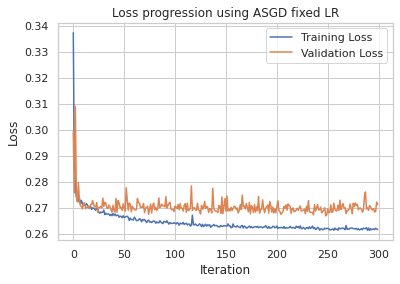

In [70]:
plt.plot(train_losses)
plt.plot(val_losses)
plt.title("Loss progression using ASGD fixed LR")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend(["Training Loss","Validation Loss"])

In [71]:
acc4=[]
for i in np.linspace(0.1,1,50):
    acc4.append(test(test_dataloader,model4,i))

Text(0.5, 1.0, 'Threshold vs Accuracy')

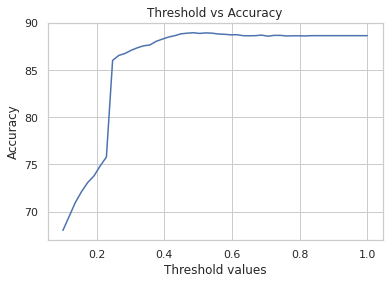

In [72]:
plt.plot(np.linspace(0.1,1,50),acc4)
plt.xlabel("Threshold values")
plt.ylabel("Accuracy")
plt.title("Threshold vs Accuracy")

In [73]:
print("The best threshold is --- ",np.linspace(0.1,1,50)[np.argmax(acc4)])
print("The best accuracy we can achieve using ASGD with constant LR is --- ",acc4[np.argmax(acc4)])

The best threshold is ---  0.48571428571428577
The best accuracy we can achieve using ASGD with constant LR is ---  88.97080507225007


In [74]:
gradient_dot4 = []
for i in range(len(pgrad)-1):
    gradient_dot4.append(np.squeeze(np.dot(pgrad[i],pgrad[i+1].T)/(pgrad_norm[i]*pgrad_norm[i+1])))

Text(0.5, 0, 'Gradient')

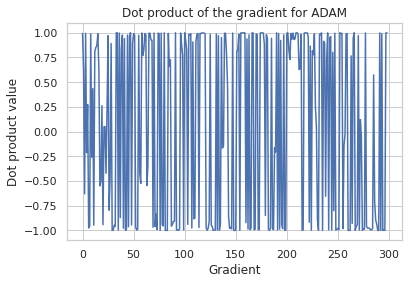

In [75]:
plt.plot(gradient_dot4)
#plt.yticks([1.2,0.0,-1.2])
plt.title("Dot product of the gradient for ADAM")
plt.ylabel("Dot product value")
plt.xlabel("Gradient")

Text(0.5, 0, 'Gradient norm value')

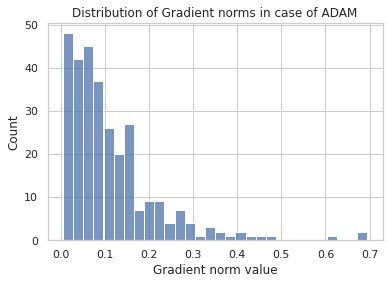

In [76]:
sns.histplot(pgrad_norm,fill=True,bins=30)
plt.title("Distribution of Gradient norms in case of ADAM")
plt.xlabel("Gradient norm value")

# ADAGRAD

In [77]:
model5 = NeuralNetwork().to(device)

In [78]:
batch_size = 64

train_dataloader = DataLoader(train_class, batch_size=batch_size, sampler = RandomSampler(X_train))
test_dataloader = DataLoader(test_class, batch_size=X_test.shape[0])
val_dataloader = DataLoader(val_class, batch_size=X_val.shape[0])

In [79]:
optimizer5 = torch.optim.Adagrad(model5.parameters(), lr=5e-3)

In [80]:
epochs = 300
train_losses = []
val_losses = []
pgrad = []
pgrad_norm = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss_print,param_grad,param_grad_norm =train(train_dataloader, model5, loss_fn, optimizer5)
    pgrad_norm.append(param_grad_norm[-2])
    pgrad.append(param_grad[-2])
    #print(param_grad[-2],"\n",param_grad_norm[-2])
    val_loss_print = validation(val_dataloader,model5,loss_fn)
    train_losses.append(sum(train_loss_print)/len(train_loss_print))
    val_losses.append(val_loss_print)
    if val_loss_print<=np.min(val_losses):
        torch.save(model.state_dict(),'/home/sysadm/UDVAS DAS/model_ADAGRAD.pt')
print("Done!")

Epoch 1
-------------------------------
Training Loss =  0.38631968058720983

 Validation Loss =  0.3289799690246582
Epoch 2
-------------------------------
Training Loss =  0.3437882115895098

 Validation Loss =  0.3264767825603485
Epoch 3
-------------------------------
Training Loss =  0.34213836984802976

 Validation Loss =  0.32595381140708923
Epoch 4
-------------------------------
Training Loss =  0.34044669113977993

 Validation Loss =  0.3240673840045929
Epoch 5
-------------------------------
Training Loss =  0.33913406816997915

 Validation Loss =  0.3231007158756256
Epoch 6
-------------------------------
Training Loss =  0.33812079652391297

 Validation Loss =  0.32282382249832153
Epoch 7
-------------------------------
Training Loss =  0.33716751294906694

 Validation Loss =  0.3214324414730072
Epoch 8
-------------------------------
Training Loss =  0.3360002863587755

 Validation Loss =  0.32075822353363037
Epoch 9
-------------------------------
Training Loss =  0.3351

Training Loss =  0.3015492538912128

 Validation Loss =  0.2932351529598236
Epoch 72
-------------------------------
Training Loss =  0.3011938499832394

 Validation Loss =  0.29284122586250305
Epoch 73
-------------------------------
Training Loss =  0.30050154873216994

 Validation Loss =  0.29240164160728455
Epoch 74
-------------------------------
Training Loss =  0.29998040283569183

 Validation Loss =  0.29201817512512207
Epoch 75
-------------------------------
Training Loss =  0.2995280578431457

 Validation Loss =  0.29161375761032104
Epoch 76
-------------------------------
Training Loss =  0.2990838968091541

 Validation Loss =  0.2911255955696106
Epoch 77
-------------------------------
Training Loss =  0.29841995353650563

 Validation Loss =  0.29060858488082886
Epoch 78
-------------------------------
Training Loss =  0.2979904720879564

 Validation Loss =  0.29040417075157166
Epoch 79
-------------------------------
Training Loss =  0.2976838860547904

 Validation Loss =

Training Loss =  0.27059953759113947

 Validation Loss =  0.2683553397655487
Epoch 142
-------------------------------
Training Loss =  0.2700731466213862

 Validation Loss =  0.2681044340133667
Epoch 143
-------------------------------
Training Loss =  0.2695552914431601

 Validation Loss =  0.2678226828575134
Epoch 144
-------------------------------
Training Loss =  0.26940475774533823

 Validation Loss =  0.26760926842689514
Epoch 145
-------------------------------
Training Loss =  0.26910237465241943

 Validation Loss =  0.26718661189079285
Epoch 146
-------------------------------
Training Loss =  0.2686897395385636

 Validation Loss =  0.2669481337070465
Epoch 147
-------------------------------
Training Loss =  0.26839287139550605

 Validation Loss =  0.2665552794933319
Epoch 148
-------------------------------
Training Loss =  0.26816506965292825

 Validation Loss =  0.26656949520111084
Epoch 149
-------------------------------
Training Loss =  0.2681486970396957

 Validation

Training Loss =  0.2565856710828916

 Validation Loss =  0.2574623227119446
Epoch 211
-------------------------------
Training Loss =  0.2567585764208225

 Validation Loss =  0.2574772834777832
Epoch 212
-------------------------------
Training Loss =  0.25645221477807173

 Validation Loss =  0.25717633962631226
Epoch 213
-------------------------------
Training Loss =  0.2563294548127386

 Validation Loss =  0.2571481466293335
Epoch 214
-------------------------------
Training Loss =  0.2561484734066809

 Validation Loss =  0.2571517527103424
Epoch 215
-------------------------------
Training Loss =  0.2561475597246729

 Validation Loss =  0.25688618421554565
Epoch 216
-------------------------------
Training Loss =  0.2559706539216668

 Validation Loss =  0.2568819224834442
Epoch 217
-------------------------------
Training Loss =  0.25593033055163394

 Validation Loss =  0.2569304406642914
Epoch 218
-------------------------------
Training Loss =  0.2559128051454371

 Validation Los

Training Loss =  0.25182750085086536

 Validation Loss =  0.25361278653144836
Epoch 280
-------------------------------
Training Loss =  0.2515693805434487

 Validation Loss =  0.2538435459136963
Epoch 281
-------------------------------
Training Loss =  0.25157491686669264

 Validation Loss =  0.253666490316391
Epoch 282
-------------------------------
Training Loss =  0.25157028821983723

 Validation Loss =  0.253600537776947
Epoch 283
-------------------------------
Training Loss =  0.25139388405915464

 Validation Loss =  0.25363287329673767
Epoch 284
-------------------------------
Training Loss =  0.25146035664912425

 Validation Loss =  0.253589004278183
Epoch 285
-------------------------------
Training Loss =  0.251172057847784

 Validation Loss =  0.2534638047218323
Epoch 286
-------------------------------
Training Loss =  0.25155145680964597

 Validation Loss =  0.2535150647163391
Epoch 287
-------------------------------
Training Loss =  0.25131434188647706

 Validation Lo

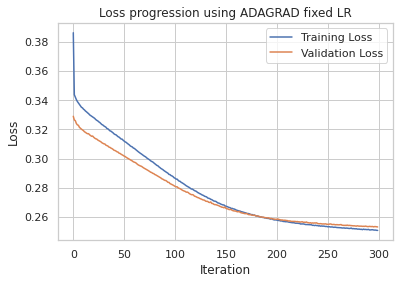

In [81]:
plt.plot(train_losses)
plt.plot(val_losses)
plt.title("Loss progression using ADAGRAD fixed LR")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend(["Training Loss","Validation Loss"])

In [82]:
acc5=[]
for i in np.linspace(0.1,1,50):
    acc5.append(test(test_dataloader,model5,i))

Text(0.5, 1.0, 'Threshold vs Accuracy')

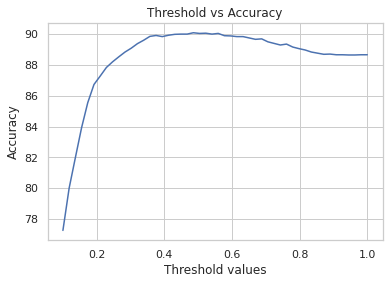

In [83]:
plt.plot(np.linspace(0.1,1,50),acc5)
plt.xlabel("Threshold values")
plt.ylabel("Accuracy")
plt.title("Threshold vs Accuracy")

In [84]:
print("The best threshold is --- ",np.linspace(0.1,1,50)[np.argmax(acc5)])
print("The best accuracy we can achieve using ASGD with constant LR is --- ",acc5[np.argmax(acc5)])

The best threshold is ---  0.48571428571428577
The best accuracy we can achieve using ASGD with constant LR is ---  90.09141846063108


In [85]:
gradient_dot5 = []
for i in range(len(pgrad)-1):
    gradient_dot5.append(np.squeeze(np.dot(pgrad[i],pgrad[i+1].T)/(pgrad_norm[i]*pgrad_norm[i+1])))

Text(0.5, 0, 'Gradient')

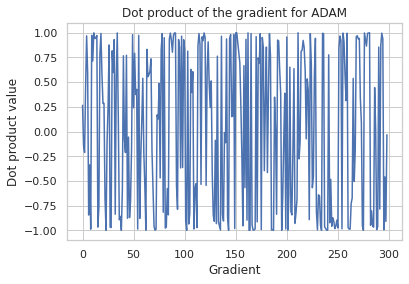

In [86]:
plt.plot(gradient_dot5)
plt.title("Dot product of the gradient for ADAM")
plt.ylabel("Dot product value")
plt.xlabel("Gradient")

Text(0.5, 0, 'Gradient norm value')

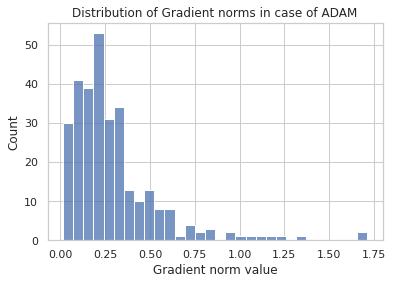

In [87]:
sns.histplot(pgrad_norm,fill=True,bins=30)
plt.title("Distribution of Gradient norms in case of ADAM")
plt.xlabel("Gradient norm value")

# RMSProp

In [88]:
model6 = NeuralNetwork().to(device)

In [89]:
batch_size = 64

train_dataloader = DataLoader(train_class, batch_size=batch_size, sampler = RandomSampler(X_train))
test_dataloader = DataLoader(test_class, batch_size=X_test.shape[0])
val_dataloader = DataLoader(val_class, batch_size=X_val.shape[0])

In [90]:
optimizer6 = torch.optim.Adagrad(model6.parameters(), lr=5e-3)

In [91]:
epochs = 300
train_losses = []
val_losses = []
pgrad = []
pgrad_norm = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss_print,param_grad,param_grad_norm =train(train_dataloader, model6, loss_fn, optimizer6)
    pgrad_norm.append(param_grad_norm[-2])
    pgrad.append(param_grad[-2])
    #print(param_grad[-2],"\n",param_grad_norm[-2])
    val_loss_print = validation(val_dataloader,model6,loss_fn)
    train_losses.append(sum(train_loss_print)/len(train_loss_print))
    val_losses.append(val_loss_print)
    if val_loss_print<=np.min(val_losses):
        torch.save(model.state_dict(),'/home/sysadm/UDVAS DAS/model_RMSProp.pt')
print("Done!")

Epoch 1
-------------------------------
Training Loss =  0.37621251433485686

 Validation Loss =  0.3297934830188751
Epoch 2
-------------------------------
Training Loss =  0.34473110452444866

 Validation Loss =  0.3271157741546631
Epoch 3
-------------------------------
Training Loss =  0.3417346789078279

 Validation Loss =  0.32491180300712585
Epoch 4
-------------------------------
Training Loss =  0.33992358157129

 Validation Loss =  0.32360148429870605
Epoch 5
-------------------------------
Training Loss =  0.33826210998525524

 Validation Loss =  0.32266899943351746
Epoch 6
-------------------------------
Training Loss =  0.3364821731442153

 Validation Loss =  0.32101207971572876
Epoch 7
-------------------------------
Training Loss =  0.3351841914834398

 Validation Loss =  0.3200923204421997
Epoch 8
-------------------------------
Training Loss =  0.33400462793581415

 Validation Loss =  0.3192933201789856
Epoch 9
-------------------------------
Training Loss =  0.3330220

Training Loss =  0.2910687950524417

 Validation Loss =  0.2839123010635376
Epoch 72
-------------------------------
Training Loss =  0.2901598276513996

 Validation Loss =  0.2831789255142212
Epoch 73
-------------------------------
Training Loss =  0.2893735236441246

 Validation Loss =  0.2823008894920349
Epoch 74
-------------------------------
Training Loss =  0.2884845277727252

 Validation Loss =  0.28179362416267395
Epoch 75
-------------------------------
Training Loss =  0.28779054344302474

 Validation Loss =  0.28102558851242065
Epoch 76
-------------------------------
Training Loss =  0.28654857313994203

 Validation Loss =  0.2799529731273651
Epoch 77
-------------------------------
Training Loss =  0.28574170092440615

 Validation Loss =  0.2793477475643158
Epoch 78
-------------------------------
Training Loss =  0.28511707094883676

 Validation Loss =  0.2784144878387451
Epoch 79
-------------------------------
Training Loss =  0.28372656310146505

 Validation Loss =  

Training Loss =  0.2531519705147454

 Validation Loss =  0.25287720561027527
Epoch 142
-------------------------------
Training Loss =  0.2527330266857388

 Validation Loss =  0.25263917446136475
Epoch 143
-------------------------------
Training Loss =  0.25267705181331346

 Validation Loss =  0.25275900959968567
Epoch 144
-------------------------------
Training Loss =  0.2527162302473579

 Validation Loss =  0.25265878438949585
Epoch 145
-------------------------------
Training Loss =  0.25259236807775015

 Validation Loss =  0.252526193857193
Epoch 146
-------------------------------
Training Loss =  0.2525670602466121

 Validation Loss =  0.2527199983596802
Epoch 147
-------------------------------
Training Loss =  0.25214502155178725

 Validation Loss =  0.2522561848163605
Epoch 148
-------------------------------
Training Loss =  0.2520451303834867

 Validation Loss =  0.25266188383102417
Epoch 149
-------------------------------
Training Loss =  0.25185630998828196

 Validation

Training Loss =  0.24843253967436876

 Validation Loss =  0.25015735626220703
Epoch 211
-------------------------------
Training Loss =  0.248562389792818

 Validation Loss =  0.25028854608535767
Epoch 212
-------------------------------
Training Loss =  0.24837192284940468

 Validation Loss =  0.25046077370643616
Epoch 213
-------------------------------
Training Loss =  0.24818766966010586

 Validation Loss =  0.2501089572906494
Epoch 214
-------------------------------
Training Loss =  0.2484151257258473

 Validation Loss =  0.25004205107688904
Epoch 215
-------------------------------
Training Loss =  0.24829603252988874

 Validation Loss =  0.25015005469322205
Epoch 216
-------------------------------
Training Loss =  0.24808393533181664

 Validation Loss =  0.2504652738571167
Epoch 217
-------------------------------
Training Loss =  0.2482485484896284

 Validation Loss =  0.25008612871170044
Epoch 218
-------------------------------
Training Loss =  0.2481297703403415

 Validati

Training Loss =  0.24669891178908973

 Validation Loss =  0.24893714487552643
Epoch 280
-------------------------------
Training Loss =  0.24675014351654534

 Validation Loss =  0.24906115233898163
Epoch 281
-------------------------------
Training Loss =  0.2466432654646912

 Validation Loss =  0.24892325699329376
Epoch 282
-------------------------------
Training Loss =  0.24675520294242434

 Validation Loss =  0.24885088205337524
Epoch 283
-------------------------------
Training Loss =  0.24660831582967682

 Validation Loss =  0.24917785823345184
Epoch 284
-------------------------------
Training Loss =  0.24658554060892626

 Validation Loss =  0.24902300536632538
Epoch 285
-------------------------------
Training Loss =  0.24676003910676397

 Validation Loss =  0.24904915690422058
Epoch 286
-------------------------------
Training Loss =  0.2466666165776927

 Validation Loss =  0.24899519979953766
Epoch 287
-------------------------------
Training Loss =  0.24650521895500144

 Val

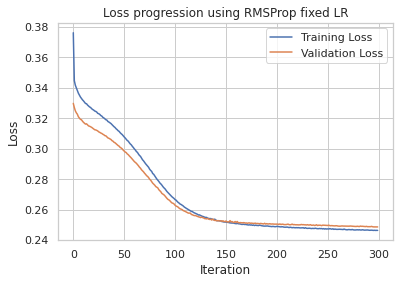

In [92]:
plt.plot(train_losses)
plt.plot(val_losses)
plt.title("Loss progression using RMSProp fixed LR")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend(["Training Loss","Validation Loss"])

In [93]:
acc6=[]
for i in np.linspace(0.1,1,50):
    acc6.append(test(test_dataloader,model6,i))

Text(0.5, 1.0, 'Threshold vs Accuracy')

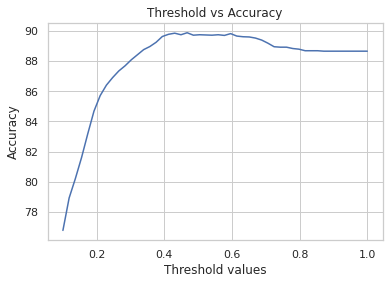

In [94]:
plt.plot(np.linspace(0.1,1,50),acc6)
plt.xlabel("Threshold values")
plt.ylabel("Accuracy")
plt.title("Threshold vs Accuracy")

In [118]:
print("The best threshold is --- ",np.linspace(0.1,1,50)[np.argmax(acc6)])
print("The best accuracy we can achieve using RMSProp with constant LR is --- ",acc6[np.argmax(acc6)])

The best threshold is ---  0.46734693877551026
The best accuracy we can achieve using RMSProp with constant LR is ---  89.8849896785609


In [96]:
gradient_dot6 = []
for i in range(len(pgrad)-1):
    gradient_dot6.append(np.squeeze(np.dot(pgrad[i],pgrad[i+1].T)/(pgrad_norm[i]*pgrad_norm[i+1])))

Text(0.5, 0, 'Gradient')

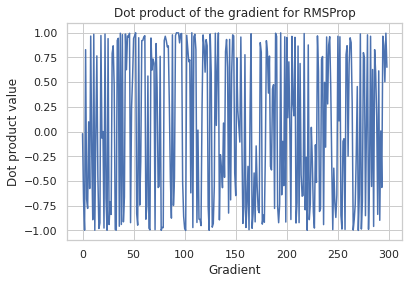

In [97]:
plt.plot(gradient_dot6)
plt.title("Dot product of the gradient for RMSProp")
plt.ylabel("Dot product value")
plt.xlabel("Gradient")

Text(0.5, 0, 'Gradient norm value')

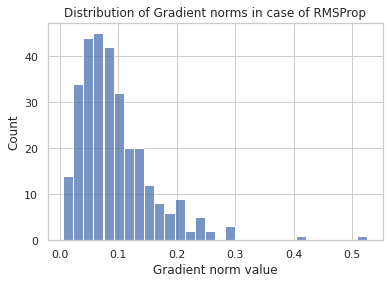

In [98]:
sns.histplot(pgrad_norm,fill=True,bins=30)
plt.title("Distribution of Gradient norms in case of RMSProp")
plt.xlabel("Gradient norm value")

## So, among all the adaptive variants of SGD, ADAGRAD stands out and shows more than 90% accuracy, so further we use learning rate schedulers and see if the performance improves.

# CosineAnnealingWarmRestarts

In [169]:
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer6,T_0 = X_train.shape[0])

In [170]:
def train(dataloader, model, loss_fn, optimizer):
    train_loss1 = []
    param_grad_norm = []
    param_grad = []
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        pred = model(X.float())
        loss = loss_fn(pred.view(X.shape[0]).float(),y.float())
        train_loss1.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        grad=0
        for i in model.parameters():
            param_grad_norm.append(torch.linalg.norm(i.grad.data).item())
            grad=i.grad.clone().detach().cpu().numpy()
            param_grad.append(grad)
    print("Training Loss = ",np.sum(train_loss1)/len(dataloader))
    return train_loss1,param_grad,param_grad_norm

In [171]:
model7 = NeuralNetwork().to(device)

In [172]:
batch_size = 64

train_dataloader = DataLoader(train_class, batch_size=batch_size, sampler = RandomSampler(X_train))
test_dataloader = DataLoader(test_class, batch_size=X_test.shape[0])
val_dataloader = DataLoader(val_class, batch_size=X_val.shape[0])

In [173]:
optimizer7 = torch.optim.Adagrad(model7.parameters(), lr=5e-3)

In [174]:
epochs = 300
train_losses = []
val_losses = []
pgrad = []
pgrad_norm = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss_print,param_grad,param_grad_norm =train(train_dataloader, model7, loss_fn, optimizer7)
    pgrad_norm.append(param_grad_norm[-2])
    pgrad.append(param_grad[-2])
    #print(param_grad[-2],"\n",param_grad_norm[-2])
    val_loss_print = validation(val_dataloader,model7,loss_fn)
    train_losses.append(sum(train_loss_print)/len(train_loss_print))
    val_losses.append(val_loss_print)
    if val_loss_print<=np.min(val_losses):
        torch.save(model.state_dict(),'/home/sysadm/UDVAS DAS/model_ADAGRAD_LRscheduler.pt')
print("Done!")

Epoch 1
-------------------------------
Training Loss =  0.35999364271910506

 Validation Loss =  0.3314705491065979
Epoch 2
-------------------------------
Training Loss =  0.3453622677109458

 Validation Loss =  0.32873642444610596
Epoch 3
-------------------------------
Training Loss =  0.342707147261109

 Validation Loss =  0.3267020285129547
Epoch 4
-------------------------------
Training Loss =  0.34038080657371367

 Validation Loss =  0.3250866234302521
Epoch 5
-------------------------------
Training Loss =  0.33845723494134766

 Validation Loss =  0.3232603073120117
Epoch 6
-------------------------------
Training Loss =  0.3362990486501443

 Validation Loss =  0.3220931589603424
Epoch 7
-------------------------------
Training Loss =  0.33464011077326955

 Validation Loss =  0.3204733431339264
Epoch 8
-------------------------------
Training Loss =  0.3327779243389765

 Validation Loss =  0.31858205795288086
Epoch 9
-------------------------------
Training Loss =  0.33052253

Training Loss =  0.2637692690497697

 Validation Loss =  0.2625812292098999
Epoch 72
-------------------------------
Training Loss =  0.2632150102143336

 Validation Loss =  0.26245352625846863
Epoch 73
-------------------------------
Training Loss =  0.26266381976881414

 Validation Loss =  0.2620859742164612
Epoch 74
-------------------------------
Training Loss =  0.2621267829127986

 Validation Loss =  0.2613883316516876
Epoch 75
-------------------------------
Training Loss =  0.26154807751828973

 Validation Loss =  0.26057350635528564
Epoch 76
-------------------------------
Training Loss =  0.26100081760774957

 Validation Loss =  0.26027846336364746
Epoch 77
-------------------------------
Training Loss =  0.26048698735357534

 Validation Loss =  0.2602158486843109
Epoch 78
-------------------------------
Training Loss =  0.26002321237265463

 Validation Loss =  0.25984394550323486
Epoch 79
-------------------------------
Training Loss =  0.2594203225590966

 Validation Loss =

Training Loss =  0.2491022330492434

 Validation Loss =  0.2522493302822113
Epoch 142
-------------------------------
Training Loss =  0.24888695460377316

 Validation Loss =  0.25273123383522034
Epoch 143
-------------------------------
Training Loss =  0.24896433162267761

 Validation Loss =  0.2522957921028137
Epoch 144
-------------------------------
Training Loss =  0.2488784899013211

 Validation Loss =  0.25249242782592773
Epoch 145
-------------------------------
Training Loss =  0.24878096961312823

 Validation Loss =  0.2523426115512848
Epoch 146
-------------------------------
Training Loss =  0.24885447943451428

 Validation Loss =  0.2530005872249603
Epoch 147
-------------------------------
Training Loss =  0.24875798914769684

 Validation Loss =  0.25231918692588806
Epoch 148
-------------------------------
Training Loss =  0.24862432529528936

 Validation Loss =  0.2522737681865692
Epoch 149
-------------------------------
Training Loss =  0.24855582656884434

 Validati

Training Loss =  0.24669845826698072

 Validation Loss =  0.2507105767726898
Epoch 211
-------------------------------
Training Loss =  0.24665259384747706

 Validation Loss =  0.2506803572177887
Epoch 212
-------------------------------
Training Loss =  0.2467931354888762

 Validation Loss =  0.25090014934539795
Epoch 213
-------------------------------
Training Loss =  0.2465703825757961

 Validation Loss =  0.25066354870796204
Epoch 214
-------------------------------
Training Loss =  0.24649258620209163

 Validation Loss =  0.25100740790367126
Epoch 215
-------------------------------
Training Loss =  0.24683458774980874

 Validation Loss =  0.2507569491863251
Epoch 216
-------------------------------
Training Loss =  0.2465557599910582

 Validation Loss =  0.2507975697517395
Epoch 217
-------------------------------
Training Loss =  0.24645584872876755

 Validation Loss =  0.25073954463005066
Epoch 218
-------------------------------
Training Loss =  0.24634383957494388

 Validati

Training Loss =  0.24530439897619113

 Validation Loss =  0.24975571036338806
Epoch 280
-------------------------------
Training Loss =  0.24533457753032145

 Validation Loss =  0.24979743361473083
Epoch 281
-------------------------------
Training Loss =  0.24526406549143068

 Validation Loss =  0.25022512674331665
Epoch 282
-------------------------------
Training Loss =  0.24533514020719913

 Validation Loss =  0.2498035877943039
Epoch 283
-------------------------------
Training Loss =  0.24522914589956554

 Validation Loss =  0.24999143183231354
Epoch 284
-------------------------------
Training Loss =  0.245086515491659

 Validation Loss =  0.2501525282859802
Epoch 285
-------------------------------
Training Loss =  0.24524694980695994

 Validation Loss =  0.24973459541797638
Epoch 286
-------------------------------
Training Loss =  0.2451351654649985

 Validation Loss =  0.24974794685840607
Epoch 287
-------------------------------
Training Loss =  0.2452299049707374

 Validat

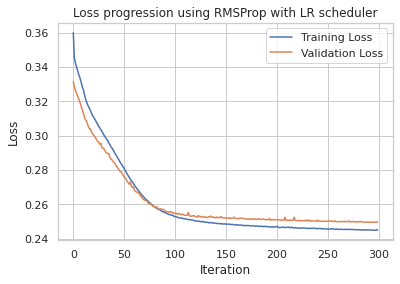

In [175]:
plt.plot(train_losses)
plt.plot(val_losses)
plt.title("Loss progression using RMSProp with LR scheduler")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend(["Training Loss","Validation Loss"])

In [176]:
acc7=[]
for i in np.linspace(0.1,1,50):
    acc7.append(test(test_dataloader,model7,i))

Text(0.5, 1.0, 'Threshold vs Accuracy')

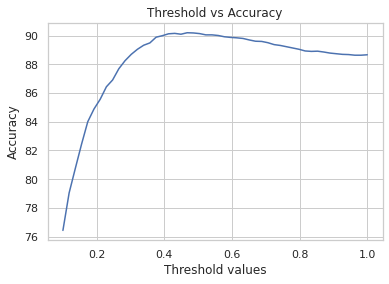

In [177]:
plt.plot(np.linspace(0.1,1,50),acc7)
plt.xlabel("Threshold values")
plt.ylabel("Accuracy")
plt.title("Threshold vs Accuracy")

In [178]:
print("The best threshold is --- ",np.linspace(0.1,1,50)[np.argmax(acc7)])
print("The best accuracy we can achieve using RMSProp with LR scheduler is --- ",acc7[np.argmax(acc7)])

The best threshold is ---  0.46734693877551026
The best accuracy we can achieve using RMSProp with LR scheduler is ---  90.19463285166617


In [179]:
gradient_dot7 = []
for i in range(len(pgrad)-1):
    gradient_dot7.append(np.squeeze(np.dot(pgrad[i],pgrad[i+1].T)/(pgrad_norm[i]*pgrad_norm[i+1])))

Text(0.5, 0, 'Gradient')

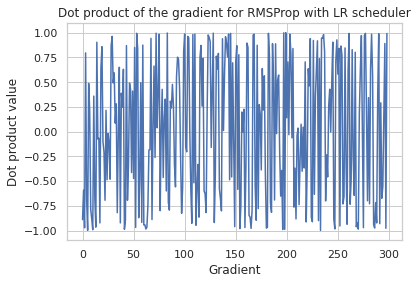

In [180]:
plt.plot(gradient_dot7)
plt.title("Dot product of the gradient for RMSProp with LR scheduler")
plt.ylabel("Dot product value")
plt.xlabel("Gradient")

Text(0.5, 0, 'Gradient norm value')

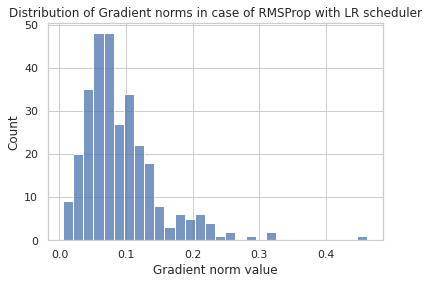

In [181]:
sns.histplot(pgrad_norm,fill=True,bins=30)
plt.title("Distribution of Gradient norms in case of RMSProp with LR scheduler")
plt.xlabel("Gradient norm value")

## Accuracy using vanilla GD algorithm ---- 88.6611618991448 %

## Highest accuracy achieved ---- 90.19463285166617 % using Adagrad with LR scheduler CosineAnnealingWarmRestarts